* Goal 1: Find examples that suggest the use of small molecules in the interaction networks
* Goal 2: Show overview of the network topologies
* Goal 3: Show overview of modifications of proteins in the interface of disease modules
* Goal 4: Show overview of the disease module overlap

- [X] Create interactomes
    - [X] Interactomes without small molecules
    - [X] Interactomes with small molecules
- [ ] Show examples
- [ ] Create some disease modules
    - [X] Select multiform proteins
    - [ ] Select diseases containing multiforms
- [ ] A) Find pairs that overlap only with modified proteoforms
- [ ] B) Find pairs that overlap at gene/protein level and not overlap at proteoform level
    - [ ] Calculate overlap scores: node overlap, jaccard index, separation
    - [ ] Make
    - [ ] Plot overlap score distribution for all selected disease pairs
    - [ ] Plot selected pairs

## Set up configuration

In [1]:
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.core.tests.test_einsum import sizes

import config
from config import LEVELS
from datasets.phegeni.filter_genes import create_filtered_file
from interactomes import get_interactome
from lib.dictionaries import read_dictionary_one_to_set, merge_dictionaries
from lib.download import download_if_not_exists
from lib.graph_database import get_query_result
from queries import QUERY_GET_NUM_PROTEOFORMS_PER_PROTEIN

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

Working directory: c:\git\pathwayanalysisplatform\proteoformnetworks


## Create disease modules

In [2]:
# PheGenI Phenotypes
download_if_not_exists("resources/PheGenI/", 
                       "PheGenI_Association.txt", 
                       "https://www.ncbi.nlm.nih.gov/projects/gap/eqtl/EpiViewBE.cgi?type=dl.tab",
                       "PheGenI All_modules")
print("PheGenI files READY")

# Filter
create_filtered_file("resources/PheGenI/PheGenI_Association.txt",
                     "resources/PheGenI/PheGenI_Association_genome_wide_significant.txt",
                     5e-8)

# Jensen Lab Diseases
download_if_not_exists("resources/Jensen/",
                       "human_disease_textmining_filtered.tsv",
                       "http://download.jensenlab.org/human_disease_textmining_filtered.tsv",
                       "Jensen Lab Diseases")
print("Jensen Lab files READY")

PheGenI files READY
Jensen Lab files READY


In [3]:
query = QUERY_GET_NUM_PROTEOFORMS_PER_PROTEIN
df = get_query_result(query)

df

,Protein,Proteoforms,NumProteoforms
0,P0CG48,"[[P0CG48], [P0CG48, 00134:152], [P0CG48, 00134...",82
1,P68431,"[[P68431], [P68431, 00046:11, 00047:12, 00064:...",52
2,Q71DI3,"[[Q71DI3], [Q71DI3, 00046:11, 00047:12, 00064:...",48
3,P02452,"[[P02452], [P02452, 00037:null], [P02452, 0003...",36
4,P08123,"[[P08123], [P08123, 00037:null], [P08123, 0003...",36
...,...,...,...
1486,Q9Y6K1,"[[Q9Y6K1], [Q9Y6K1, 01149:null]]",2
1487,Q9Y6Q2,"[[Q9Y6Q2], [Q9Y6Q2, 01150:null]]",2
1488,Q9Y6Q9,"[[Q9Y6Q9], [Q9Y6Q9, 00046:857]]",2
1489,Q9Y6W8,"[[Q9Y6W8-1], [Q9Y6W8-1, 00048:180]]",2


In [4]:
file_phegeni = "resources/PheGenI/PheGenI_Association_genome_wide_significant.txt"
df_diseases = pd.read_csv(file_phegeni, sep="\t")
df_diseases

,#,Trait,SNP rs,Context,Gene,Gene ID,Gene 2,Gene ID 2,Chromosome,Location,P-Value,Source,PubMed,Analysis ID,Study ID,Study Name
0,2,1-Alkyl-2-acetylglycerophosphocholine Esterase,7528419,UTR-3,CELSR2,1952,CELSR2,1952,1,109274569,0.00,NHGRI,22003152,0,NaN,NaN
1,3,1-Alkyl-2-acetylglycerophosphocholine Esterase,12740374,UTR-3,CELSR2,1952,CELSR2,1952,1,109274967,0.00,NHGRI,23118302,0,NaN,NaN
2,4,1-Alkyl-2-acetylglycerophosphocholine Esterase,599839,nearGene-3,PSRC1,84722,PSRC1,84722,1,109279543,0.00,NHGRI,20442857,0,NaN,NaN
3,5,1-Alkyl-2-acetylglycerophosphocholine Esterase,600550,intron,MS4A4E,643680,MS4A4E,643680,11,60230192,0.00,NHGRI,23118302,0,NaN,NaN
4,6,1-Alkyl-2-acetylglycerophosphocholine Esterase,964184,intron,ZPR1,8882,ZPR1,8882,11,116778200,0.00,NHGRI,22003152,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30210,136499,von Willebrand Factor,8176704,intron,ABO,28,ABO,28,9,133260147,0.00,NHGRI,26486471,0,NaN,NaN
30211,136500,von Willebrand Factor,687621,intron,ABO,28,ABO,28,9,133261661,0.00,NHGRI,20231535,0,NaN,NaN
30212,136501,von Willebrand Factor,643434,intron,ABO,28,ABO,28,9,133266941,0.00,NHGRI,23381943,0,NaN,NaN
30213,136502,von Willebrand Factor,505922,intron,ABO,28,ABO,28,9,133273812,0.00,NHGRI,23381943,0,NaN,NaN


In [5]:
map_disease_to_genes1 = read_dictionary_one_to_set("resources/PheGenI/", "PheGenI_Association_genome_wide_significant.txt", col_indices=(1, 4), ignore_header=True)
map_disease_to_genes2 = read_dictionary_one_to_set("resources/PheGenI/", "PheGenI_Association_genome_wide_significant.txt", col_indices=(1, 6), ignore_header=True)
df_diseases.columns
map_disease_to_genes = merge_dictionaries(map_disease_to_genes1, map_disease_to_genes2)
#map_disease_to_genes
print(f"Got map of {len(map_disease_to_genes.keys())} diseases to genes")

Got map of 873 diseases to genes


In [6]:
df_disease_to_genes = pd.DataFrame(data=[(d, len(g)) for d, g in map_disease_to_genes.items()], columns=["Disease", "Num"])
df_disease_to_genes['Entity'] = config.genes
df_disease_to_genes.sort_values(["Num"], ascending=False, inplace=True)
df_disease_to_genes

,Disease,Num,Entity
117,Body Mass Index,646,genes
637,Platelet Function Tests,594,genes
116,Body Height,520,genes
185,"Cholesterol, HDL",391,genes
109,Blood Pressure,331,genes
...,...,...,...
647,Premature Birth,1,genes
165,Caudate Nucleus,1,genes
169,Cerebral Amyloid Angiopathy,1,genes
243,Depression,1,genes


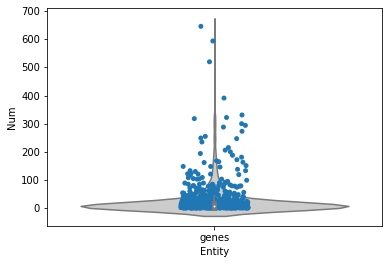

In [7]:
sns.violinplot(x="Entity", y="Num", data=df_disease_to_genes, color="0.8")
sns.stripplot(x="Entity", y="Num", data=df_disease_to_genes, jitter=True, zorder=1)
plt.show()

In [8]:
df_disease_to_genes = df_disease_to_genes[df_disease_to_genes['Num']<=100]
df_disease_to_genes

,Disease,Num,Entity
172,Cerebrospinal Fluid,99,genes
323,Fibrinogen,95,genes
549,Multiple Sclerosis,92,genes
220,Creatinine,92,genes
504,Macular Degeneration,90,genes
...,...,...,...
647,Premature Birth,1,genes
165,Caudate Nucleus,1,genes
169,Cerebral Amyloid Angiopathy,1,genes
243,Depression,1,genes


In [9]:
map_genes_to_proteins = read_dictionary_one_to_set(config.GRAPHS_PATH, "mapping_proteins_to_genes.tsv", col_indices=(1, 0))
df_genes_to_proteins = pd.DataFrame(data=[(g,len(ps)) for g, ps in map_genes_to_proteins.items()], columns=["Genes", "NumProteins"])
df_genes_to_proteins.sort_values(["NumProteins"], ascending=False, inplace=True)
df_genes_to_proteins

,Genes,NumProteins
830,HLA-B,36
831,HLA-A,21
833,HLA-C,14
3765,HLA-DRB1,13
4551,KIF5C,2
...,...,...
3665,TLE3,1
3666,TLE4,1
3667,TLE1,1
3668,KMT2D,1


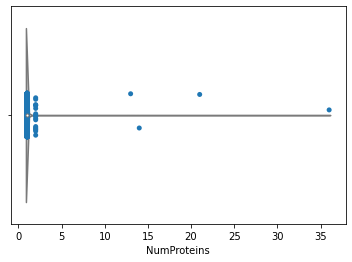

In [10]:
genes_arr=["Genes"]*len(df_genes_to_proteins)
sns.violinplot(x=df_genes_to_proteins["NumProteins"], color="0.8")
sns.stripplot(x=df_genes_to_proteins["NumProteins"], jitter=True, zorder=1)
plt.show()

In [19]:
filter_genes = df_genes_to_proteins[df_genes_to_proteins["NumProteins"] > 5]
filter_genes = set(filter_genes['Genes'])
filter_diseases = set()
for d, gs in map_disease_to_genes.items():
    if bool(gs & filter_genes):
        filter_diseases.add(d)
print(f"Diseases to delete: \n\n {filter_diseases}")
df_sel_diseases = df_disease_to_genes[~df_disease_to_genes['Disease'].isin(filter_diseases)]
df_sel_diseases


Diseases to delete: 

 {'Liver Cirrhosis, Biliary', 'C-Reactive Protein', 'Behcet Syndrome', 'Multiple Sclerosis', 'Staphylococcus', 'Asthma', 'Cryoglobulinemia', 'Lupus Erythematosus, Systemic', 'Oligoclonal Bands', 'Menarche', 'Crohn Disease', 'Parkinson Disease', 'Schizophrenia', 'Tonsillectomy', 'Inflammatory Bowel Diseases', 'Alzheimer Disease', 'Body Height', 'Hodgkin Disease', 'beta 2-Microglobulin', 'Epstein-Barr Virus Nuclear Antigens', 'Arthritis, Psoriatic', 'Monocytes', 'Triglycerides', 'Uveomeningoencephalitic Syndrome', 'Dermatitis, Atopic', 'Anti-Neutrophil Cytoplasmic Antibody-Associated Vasculitis', 'Lymphoma, Large B-Cell, Diffuse', 'Cholesterol', 'Psoriasis', 'Hepatitis B, Chronic', 'Staphylococcus aureus', 'Breast Neoplasms', 'Arthritis, Rheumatoid', 'Glomerulonephritis, IGA', 'Leukocytes', 'Leprosy', 'Agranulocytosis', 'Antibodies', 'Pulmonary Surfactant-Associated Protein D', 'Uterine Cervical Neoplasms', 'Hepatitis C, Chronic', 'Narcolepsy', 'Colitis, Ulcerative'

,Disease,Num,Entity
172,Cerebrospinal Fluid,99,genes
323,Fibrinogen,95,genes
220,Creatinine,92,genes
504,Macular Degeneration,90,genes
424,"Influenza A Virus, H1N1 Subtype",89,genes
...,...,...,...
647,Premature Birth,1,genes
165,Caudate Nucleus,1,genes
169,Cerebral Amyloid Angiopathy,1,genes
243,Depression,1,genes


In [29]:
map_disease_to_proteins = {disease: set() for disease in df_sel_diseases["Disease"]}
for disease in df_sel_diseases["Disease"]:
    for g in map_disease_to_genes[disease]:
        if g in map_genes_to_proteins:
            for protein in map_genes_to_proteins[g]:
                map_disease_to_proteins[disease].add(protein)
#map_disease_to_proteins

In [30]:
map_disease_to_numproteins = {d: len(g) for d, g in map_disease_to_proteins.items()}
df_disease_to_proteins = pd.DataFrame(data=map_disease_to_numproteins.items(), columns=["Disease", "Num"])
df_disease_to_proteins['Entity'] = config.proteins
df_disease_to_proteins.sort_values(["Num"], ascending=False, inplace=True)
df_disease_to_proteins

,Disease,Num,Entity
3,Macular Degeneration,54,proteins
1,Fibrinogen,54,proteins
0,Cerebrospinal Fluid,51,proteins
6,Hematocrit,48,proteins
11,Hemoglobins,47,proteins
...,...,...,...
705,Neurofibrillary Tangles,0,proteins
647,Methadone,0,proteins
703,"Diet, High-Fat",0,proteins
648,"Memory, Episodic",0,proteins


In [31]:
df_disease_to_entitites = pd.concat([df_disease_to_genes, df_disease_to_proteins])
df_disease_to_entitites.sort_values(by=["Disease"], inplace=True)
df_disease_to_entitites

,Disease,Num,Entity
0,1-Alkyl-2-acetylglycerophosphocholine Esterase,13,genes
211,1-Alkyl-2-acetylglycerophosphocholine Esterase,8,proteins
1,3-hydroxy-1-methylpropylmercapturic acid,42,genes
64,3-hydroxy-1-methylpropylmercapturic acid,11,proteins
546,"ADAMTS13 protein, human",2,proteins
...,...,...,...
381,thyroid microsomal antibodies,2,proteins
871,von Willebrand Factor,14,genes
194,von Willebrand Factor,6,proteins
651,ziprasidone,1,proteins


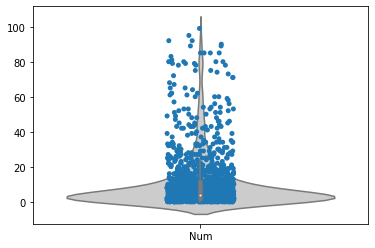

In [32]:
sns.violinplot(data=df_disease_to_entitites, color="0.8")
sns.stripplot(data=df_disease_to_entitites, jitter=True, zorder=1)
plt.show()

In [35]:
map_protein_to_diseases = {}
for d, ps in map_disease_to_proteins.items():
    for p in ps:
        if not p in map_protein_to_diseases.keys():
            map_protein_to_diseases[p] = set()
        map_protein_to_diseases[p].add(d)
map_protein_to_diseases

{'Q29980': {'Cerebrospinal Fluid',
  'Eosinophils',
  'Metabolic Syndrome X',
  'Myositis',
  'Neonatal Systemic lupus erythematosus',
  'Severe Dengue'},
 'Q13093': {'1-Alkyl-2-acetylglycerophosphocholine Esterase',
  'Cerebrospinal Fluid'},
 'Q9BXR6': {'Blood Coagulation Factors',
  'Cerebrospinal Fluid',
  'Macular Degeneration'},
 'O15389': {'Cerebrospinal Fluid'},
 'Q16610': {'Cerebrospinal Fluid'},
 'Q9UI12': {'Cerebrospinal Fluid'},
 'P04196': {'Cerebrospinal Fluid', 'Partial Thromboplastin Time'},
 'Q29983': {'Cerebrospinal Fluid',
  'Drug Resistance',
  'Graves Disease',
  'HIV',
  'Hypersensitivity',
  'Spondylitis, Ankylosing',
  'Trichloroethylene'},
 'Q9UHL4': {'Cerebrospinal Fluid'},
 'Q02083': {'Cerebrospinal Fluid'},
 'P28223': {'Cerebrospinal Fluid'},
 'P17213': {'Cerebrospinal Fluid'},
 'P08887': {'Aortic Aneurysm, Abdominal',
  'Cerebrospinal Fluid',
  'Coronary Artery Disease',
  'Fibrinogen',
  'Interleukin-6',
  'Receptors, Interleukin-6'},
 'P10643': {'Cerebrospi

In [37]:
map_protein_to_numdiseases = {p: len(ds) for p, ds in map_protein_to_diseases.items()}
df_p_nd = pd.DataFrame(data=map_protein_to_numdiseases.items(), columns=["Protein", "NumDiseases"])
df_p_nd.sort_values(["NumDiseases"], ascending=False, inplace=True)
df_p_nd

,Protein,NumDiseases
256,P16442,36
134,Q14397,31
270,O60427,24
176,P02654,23
278,Q9C0B1,15
...,...,...
1056,Q9NRZ5,1
1053,Q96K12,1
1052,P21926,1
1051,Q16621,1


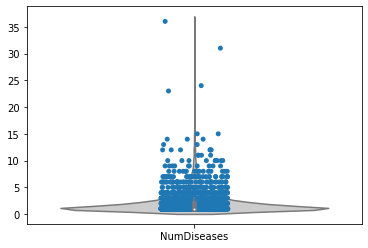

In [38]:
sns.violinplot(data=df_p_nd, color="0.8")
sns.stripplot(data=df_p_nd, jitter=True, zorder=1)
plt.show()

In [41]:
filter_proteins = df_p_nd[df_p_nd['NumDiseases'] > 10]
filter_proteins = set(filter_proteins["Protein"])
filter_proteins
filter_diseases = set()
for d, ps in map_disease_to_proteins.items():
    if bool(ps & filter_proteins):
        filter_diseases.add(d)
print(f"Diseases to delete: \n\n {filter_diseases}")
df_sel_diseases = df_disease_to_genes[~df_disease_to_genes['Disease'].isin(filter_diseases)]
df_sel_diseases


Diseases to delete: 

 {'Mental Processes', 'Oropharyngeal Neoplasms', 'P-Selectin', 'Memory', 'Leptin', 'Neoplasms', 'gamma-Glutamyltransferase', 'Forced Expiratory Volume', 'Fibrinogen', 'Pancreatic Carcinoma', 'Graves Disease', 'Lipoproteins', 'Intraocular Pressure', 'Factor VIII', 'Amyloidosis, Cerebral, with Spongiform Encephalopathy', 'Vascular Endothelial Growth Factors', 'Testicular Neoplasms', 'Arachidonic Acid', 'Papillomavirus Vaccines', 'Neuropsychological Tests', 'Renal Insufficiency, Chronic', 'Prostate-Specific Antigen', 'Thyrotropin', 'Ferritins', 'Adiponectin', 'Spondylitis, Ankylosing', 'Adenocarcinoma of lung', 'Anthropometry', 'Sphingolipids', 'Rhinitis, Allergic, Seasonal', 'Atherosclerosis', 'Myopia', 'Common Variable Immunodeficiency', 'Alopecia', 'Cholangitis, Sclerosing', 'Mortality', 'Diabetes Mellitus', 'Linoleic Acid', 'Eicosapentaenoic Acid', 'Eyebrows', 'alpha-Linolenic Acid', 'Thrombosis', 'Mannose', 'Hypersensitivity', 'Hemoglobins', 'Endothelial Growth 

,Disease,Num,Entity
549,Multiple Sclerosis,92,genes
618,Parkinson Disease,89,genes
424,"Influenza A Virus, H1N1 Subtype",89,genes
588,Optic Disk,85,genes
245,"Dermatitis, Atopic",81,genes
...,...,...,...
647,Premature Birth,1,genes
165,Caudate Nucleus,1,genes
169,Cerebral Amyloid Angiopathy,1,genes
243,Depression,1,genes


In [ ]:
# Select proteins with multiple proteoforms

selected_proteins = set(df["Protein"].unique())
selected_proteins

# Select proteins that do not participate in many diseases



In [ ]:
selected_diseases = set()
for disease, proteins in map_disease_to_proteins.items():
    if proteins & selected_proteins:
        selected_diseases.add(disease)
selected_diseases

In [ ]:
len(selected_diseases)

In [ ]:

file_vertices = "resources/Reactome/interactome_indexed_vertices.tsv"
file_edges = "resources/Reactome/interactome_edges.tsv"
file_indexes = "resources/Reactome/interactome_vertices"
file_proteins_to_genes = "resources/Reactome/mapping_proteins_to_genes.tsv"
file_proteins_to_proteoforms = "resources/Reactome/mapping_proteins_to_proteoforms.tsv"
output_path = "resources/PheGenI/modules/"

In [ ]:

pass
# Generates module files: gene_modules.tsv, protein_modules.tsv and proteoform_modules.tsv
# Generates single module files at each level: gene, protein and proteoform file for each trait
# Module sizes for genes, protein and proteoform levels
# Variation in module sizes when going from one level to the other
# Three files (for genes, proteins and proteoforms) with the Overlap similarity of each 
# pair of traits.
# Creates a file with a selection of trait pair examples which show decrease in the overlap.

In [ ]:
args = {
    "modules_file": "resources/PheGenI/PheGenI_Association_genome_wide_significant.txt",
    "gene_vertices": "resources/Reactome/genes_vertices.tsv",
    "protein_vertices": "resources/Reactome/proteins_vertices.tsv",
    "proteoform_vertices": "resources/Reactome/proteoforms_vertices.tsv",
    "small_molecules_vertices": "resources/Reactome/proteoforms_small_molecules_vertices.tsv",
    "gene_edges": "resources/Reactome/genes_interactions.tsv",
    "protein_edges": "resources/Reactome/proteins_interactions.tsv",
    "proteoform_edges": "resources/Reactome/proteoforms_interactions.tsv",
    "proteins_to_genes": "resources/UniProt/mapping_proteins_to_genes.tsv",
    "proteins_to_proteoforms": "resources/UniProt/mapping_proteins_to_proteoforms.tsv",
    "output_path": "reports/All_modules/"
}

result = subprocess.check_output("dir", stderr=subprocess.STDOUT, shell=True)

print(result.decode())

## Compare disease modules accross levels

In [ ]:
sizes_dict_connected = {level: pd.read_csv(f"reports/All_modules/module_sizes_{level}.tsv", sep="\t") for level in LEVELS}
sizes_dict_disconnected = {level: pd.read_csv(f"reports/modules_keep_disconnected/module_sizes_{level}.tsv", sep="\t") for level in LEVELS}
for level in LEVELS:
    print(f"\n{level}")
    print(sizes_dict_connected[level].describe())
    print(sizes_dict_disconnected[level].describe())
    sizes_dict_connected[level]["CONNECTEDNESS"] = "connected"
    sizes_dict_disconnected[level]["CONNECTEDNESS"] = "disconnected"

sizes_df_connected = pd.concat(sizes_dict_connected, names=["level", "index"])
sizes_df_disconnected = pd.concat(sizes_dict_disconnected, names=["level", "index"])
# sizes_df[sizes_df.index.get_level_values("level") == "genes"]
# sizes_df = pd.concat([sizes_df_connected, sizes_dict_disconnected], names=["level", "index"])
# sizes_df
sizes_df_connected["LEVEL"] = sizes_df_connected.index.get_level_values("level")
sizes_df_disconnected["LEVEL"] = sizes_df_disconnected.index.get_level_values("level")
sizes_df = pd.concat([sizes_df_connected, sizes_df_disconnected])
sizes_df

In [ ]:
# Do the following plots for the All_modules in two cases: keeping disconnected nodes and removing them
    # Jitter plot showing the sizes for genes, proteins and proteoforms
    # Jitter plot showing the difference in size fom genes to proteins and from proteins to proteoforms.
# sizes_df = pd.DataFrame()
# for level in levels:
#     sizes_df[f"SIZES_{level.upper()}"] = sizes_dict[level]["SIZES"]

sns.set(style="ticks")
g = sns.FacetGrid(sizes_df, col="LEVEL", height=4, aspect=.5, hue="LEVEL", palette="Set2")
g.map(sns.barplot, "CONNECTEDNESS", "SIZE")
plt.show()

ax = sns.boxplot(x="SIZE", y="LEVEL", data=sizes_df_connected, whis=np.inf)
ax = sns.stripplot(x="SIZE", y="LEVEL", data=sizes_df_connected, jitter=True, color=".3")
plt.show()

ax = sns.violinplot(x="SIZE", y="LEVEL", data=sizes_df_connected, inner=None, color=".8")
ax = sns.stripplot(x="SIZE", y="LEVEL", data=sizes_df_connected, jitter=True)
plt.show()

g = sns.catplot(x="LEVEL", y="SIZE",
                hue="LEVEL", col="CONNECTEDNESS",
                data=sizes_df, kind="strip",
                jitter=True,
                height=4, aspect=.7);
plt.show()

g = sns.catplot(x="CONNECTEDNESS", y="SIZE",
                hue="CONNECTEDNESS", col="LEVEL",
                data=sizes_df, kind="strip",
                jitter=True,
                height=4, aspect=.7);
plt.show()

g = sns.catplot(x="SIZE", y="LEVEL", hue="CONNECTEDNESS", data=sizes_df, kind="violin")
plt.show()

g = sns.catplot(x="SIZE", y="CONNECTEDNESS", hue="LEVEL", data=sizes_df, kind="violin")
plt.show()

In [ ]:
# Calculate and plot size variation
sizes_df = pd.concat(
    [pd.read_csv(f"reports/All_modules/module_sizes_{level}.tsv", sep="\t", names=["MODULES", f"SIZE_{level.upper()}"], header=0)[f"SIZE_{level.upper()}"] for level in LEVELS], 
    axis=1)

sizes_df[f"VARIATION_GENES_TO_PROTEINS"] = sizes_df["SIZE_PROTEINS"] - sizes_df["SIZE_GENES"]
sizes_df[f"VARIATION_PROTEINS_TO_PROTEOFORMS"] = sizes_df["SIZE_PROTEOFORMS"] - sizes_df["SIZE_PROTEINS"]

sizes_df['PERCENTAGE_GENES_TO_PROTEINS'] = sizes_df['VARIATION_GENES_TO_PROTEINS']*100/sizes_df['SIZE_GENES']
sizes_df['PERCENTAGE_PROTEINS_TO_PROTEOFORMS'] = sizes_df['VARIATION_PROTEINS_TO_PROTEOFORMS']*100/sizes_df['SIZE_PROTEINS']
sizes_df.fillna(0, inplace=True)
# sizes_df['PERCENTAGE_PROTEINS_TO_PROTEOFORMS'].unique()
sizes_df

In [ ]:
size_variation = pd.concat({"GENES_TO_PROTEINS":sizes_df["VARIATION_GENES_TO_PROTEINS"], 
                            "PROTEINS_TO_PROTEOFORMS": sizes_df[f"VARIATION_PROTEINS_TO_PROTEOFORMS"]
                           }, names=["STEP", "INDEX"], axis=0)
size_variation = size_variation.to_frame()
size_variation["STEP"] = size_variation.index.get_level_values("STEP")
size_variation.columns = ["VARIATION", "STEP"]

size_variation

In [ ]:
ax = sns.boxplot(x="VARIATION", y="STEP", data=size_variation, whis=np.inf)
ax = sns.stripplot(x="VARIATION", y="STEP", data=size_variation,
                   jitter=True, color=".3").set_title("SIZE VARIATION AT LEVEL TRANSITION")
plt.show()

ax = sns.violinplot(x="STEP", y="VARIATION", data=size_variation, inner=None, color=".8")
ax = sns.stripplot(x="STEP", y="VARIATION", data=size_variation, jitter=True).set_title("SIZE VARIATION AT LEVEL TRANSITION")
plt.show()

In [ ]:
percentage_variation = pd.concat({"GENES_TO_PROTEINS":sizes_df["PERCENTAGE_GENES_TO_PROTEINS"], 
                            "PROTEINS_TO_PROTEOFORMS": sizes_df[f"PERCENTAGE_PROTEINS_TO_PROTEOFORMS"]
                           }, names=["STEP", "INDEX"], axis=0)
percentage_variation = percentage_variation.to_frame()
percentage_variation["STEP"] = percentage_variation.index.get_level_values("STEP")
percentage_variation.columns = ["PERCENTAGE", "STEP"]

percentage_variation

In [ ]:
ax = sns.boxplot(x="PERCENTAGE", y="STEP", data=percentage_variation, whis=np.inf)
ax = sns.stripplot(x="PERCENTAGE", y="STEP", data=percentage_variation,
                   jitter=True, color=".3").set_title("PERCENTAGE OF SIZE VARIATION AT LEVEL TRANSITION")
plt.show()

ax = sns.violinplot(x="STEP", y="PERCENTAGE", data=percentage_variation, inner=None, color=".8")
ax = sns.stripplot(x="STEP", y="PERCENTAGE", data=percentage_variation, jitter=True).set_title("PERCENTAGE OF SIZE VARIATION AT LEVEL TRANSITION")
plt.show()

## Overlap analysis

In [ ]:
scores = {level: pd.read_csv(f"reports/scores_{level}_overlap_similarity.tsv", sep='\t') for level in LEVELS}
assert len({len(scores[level]) for level in LEVELS}) == 1, "Error: the number of All_modules vary among levels."

In [ ]:
import matplotlib.pyplot as plt

bins = 250
plt.figure(figsize=(13, 6), )
for level in LEVELS:
    sns.distplot(scores[level]['SCORE'] , hist = True, kde = True, kde_kws = {'linewidth': 1}, label=level, bins=bins)
plt.ylim(0, 20)
plt.legend(prop={'size': 16}, title = 'Overlap score density distribution')
plt.title('Overlap score distribution')
plt.xlabel('Overlap score')
plt.ylabel('Density')
plt.show()

In [ ]:
df = pd.DataFrame(scores['genes'][['SCORE', 'OVERLAP_SIZE']])
df.columns = ['SCORE_GENES', 'OVERLAP_SIZE_GENES']
for level in ['proteins', 'proteoforms']:
    df['OVERLAP_SIZE_' + level.upper()] = scores[level]['OVERLAP_SIZE']
    df['SCORE_' + level.upper()] = scores[level]['SCORE']
df['SCORE_VARIATION'] = df['SCORE_PROTEOFORMS'] - df['SCORE_GENES'] 
df['SIZE_PERCENTAGE_VARIATION'] = scores['genes'].apply(lambda x: sizes['PERCENTAGE_VARIATION'].loc[x['TRAIT1']] + sizes['PERCENTAGE_VARIATION'].loc[x['TRAIT2']], axis=1)
df.index = scores['genes'].apply(lambda x: (x['TRAIT1'], x['TRAIT2']), axis=1)
df

In [ ]:
plt.figure(figsize=(13, 6))
plt.scatter(df['SCORE_VARIATION'], df['SIZE_PERCENTAGE_VARIATION'], alpha=0.5)
plt.title('Variation in size VS variation in overlap')
plt.xlabel('Size percentage variation')
plt.ylabel('Overlap variation')
plt.show()

In [ ]:
min_overlap_size = 10
max_overlap_size = 20

overlap_data = {level: pd.read_csv(f"reports/All_modules/pairs_overlap_data_{level}.tsv") for level in LEVELS}


In [ ]:
# NODE_OVERLAP_SIZE_VARIATION_GENES_TO_PROTEINS
# NODE_OVERLAP_SIZE_VARIATION_PROTEINS_TO_PROTEOFORMS
# NODE_INTERFACE_SIZE_VARIATION_GENES_TO_PROTEINS
# NODE_INTERFACE_SIZE_VARIATION_PROTEINS_TO_PROTEOFORMS
# NODE_INTERFACE_SIZE_VARIATION_GENES_TO